### Image OCR to recognise hand-written text in images and captchas

1) Image OCR with [Keras](https://keras.io/examples/vision/captcha_ocr/) 2.0 using CNN, RNN and CTC

2) Handwritten Text [Recognition](https://github.com/githubharald/SimpleHTR) from Images using Beam Search. [Blog](https://towardsdatascience.com/build-a-handwritten-text-recognition-system-using-tensorflow-2326a3487cd5). 

Blog [Part 2](https://towardsdatascience.com/faq-build-a-handwritten-text-recognition-system-using-tensorflow-27648fb18519), [Part 3](https://towardsdatascience.com/what-a-text-recognition-system-actually-sees-6c04864b8a98), [Part 4 CTC](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c), [Part 5 Beam](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7)

Other articles on [Beam](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/) Search.

#### Import files

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import IPython.core.debugger as db
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Download Captcha dataset

In [ ]:
%%bash
curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    227      0 --:--:-- --:--:-- --:--:--   227
100 8863k  100 8863k    0     0  7312k      0  0:00:01  0:00:01 --:--:-- 42.1M


#### Pre-process data labels and create vocab

In [ ]:
#----------------------------------------------------
# List all the image files in the dataset and extract the
# characters from their filenames to prepare the vocabulary
#----------------------------------------------------
def prepare_vocab(image_dir):

  # The image filename without the .png extension is the target label of characters in the Captcha. 

  # Get list of all the '.png' image files and extract their filename stems as strings
  labels = [img_path.stem for img_path in image_dir.glob("*.png")]
  num_images = len(labels)

  # Set of all unique characters in labels
  characters = set(char for label in labels for char in label)

  # Maximum length of any captcha in the dataset
  max_label_len = max([len(label) for label in labels])

  print(f'{len(labels)} labels. eg {labels[:5]}. Max length {max_label_len}' )
  print(f'{len(characters)} vocabulary characters {characters}')

  # Mapping characters to integers
  char_to_num = layers.experimental.preprocessing.StringLookup(
      vocabulary=list(characters), num_oov_indices=0, mask_token=None
  )

  # Mapping integers back to original characters
  num_to_char = layers.experimental.preprocessing.StringLookup(
      vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
  )

  return (char_to_num, num_to_char, num_images, max_label_len)

# Path to the data directory
image_dir = Path("./captcha_images_v2/")

# Prepare the vocab and reverse vocab
char_to_num, num_to_char, num_images, max_label_len = prepare_vocab(image_dir)
char_vocab = char_to_num.get_vocabulary()
print(f'c2i is {char_vocab}')
print(f'i2c is {num_to_char(tf.constant(list(range(len(char_vocab)))))}')

1040 labels. eg ['3xcgg', 'pdw38', 'wnmyn', 'y2xg4', 'c3572']. Max length 5
19 vocabulary characters {'b', '6', 'f', 'e', 'd', 'x', 'c', '2', '7', '5', 'n', 'p', '8', 'g', '4', 'm', '3', 'y', 'w'}
c2i is ['b', '6', 'f', 'e', 'd', 'x', 'c', '2', '7', '5', 'n', 'p', '8', 'g', '4', 'm', '3', 'y', 'w']
i2c is [b'b' b'6' b'f' b'e' b'd' b'x' b'c' b'2' b'7' b'5' b'n' b'p' b'8' b'g'
 b'4' b'm' b'3' b'y' b'w']


#### Create Datasets

In [ ]:
#----------------------------------------------------
# Get the image label by extracting the filename stem
#----------------------------------------------------
def get_label(img_path):
  label = Path(str(img_path)).stem
  return label

#----------------------------------------------------
# This uses a native Tensorflow approach to parse the image path to
# extract the label. This has now been obsoleted by the TF wrapper over the
# Python based Path approach
#----------------------------------------------------
def OLD_get_label(img_path):
  # Split the path into a list of path elements. The last element is the filename
  # with extension. Split that again into the stem and extension.
  path_parts = tf.strings.split(img_path, os.path.sep)
  filename_parts = tf.strings.split(path_parts[-1], '.')
  label = filename_parts[0]
  return label

#----------------------------------------------------
# Given an image path, load the image data and pre-process it
# Also extract the label of the image. This function is used to
# obtain one training sample that can be passed to the model.
#
# Note that only TF functions can be used here, because we are only
# building up the function graph at first. The actual execution happens
# when the data gets fetched. So Python functions cannot be invoked
# directly, but have to be wrapped by a TF Python wrapper.
#----------------------------------------------------
def process_image(img_path):
  # 1. Read image
  img = tf.io.read_file(img_path)
  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])
  # 6. Extract the label from the image path using a Python function. The tensor
  # shape must be set explicitly after invoking the Python function.
  [label,] = tf.py_function(get_label, [img_path], [tf.string])
  label.set_shape([])
  # 7. Map the characters in label to numbers
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  # 8. Return a dict as our model is expecting two inputs
  return {"image": img, "label": label}

#----------------------------------------------------
# Configure the TF Dataset for improved performance by enabling some settings
#----------------------------------------------------
def ds_perf(ds, batch_size):
  # Enable caching on the dataset
  ds = ds.cache()
  # Enable shuffling. Use a buffer size equal to the length of the dataset for
  # ideal shuffling
  ds = ds.shuffle(buffer_size=1000)
  # Enable batching by defining the batch size
  ds = ds.batch(batch_size)
  # Enable pre-fetching so that the next batch gets fetched while the previous batch
  # is being executed by the model
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

#----------------------------------------------------
# Prepare the end-to-end data pipeline
#----------------------------------------------------
def image_pipeline(image_dir, num_images, batch_size):
  # Create the dataset from image files in the directory
  image_ds = tf.data.Dataset.list_files(str(image_dir/'*'), shuffle=False)
  image_ds = image_ds.shuffle(buffer_size=num_images, reshuffle_each_iteration=False)

  # Test-train split, using the ds.skip() and ds.take() methods. This is the standard
  # way to split TF Datasets
  val_size = int(num_images * 0.2)
  train_ds = image_ds.skip(val_size)
  val_ds = image_ds.take(val_size)

  # Define the function to process each element in the dataset and prepare it for
  # the model. Here we only define the function. It is actually executed only when
  # we start fetching batches of data to feed to the model.
  # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
  train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE)
  val_ds = val_ds.map(process_image, num_parallel_calls=AUTOTUNE)

  # Enable the performance settings
  train_ds = ds_perf(train_ds, batch_size)
  val_ds = ds_perf(val_ds, batch_size)

  return (train_ds, val_ds)

# ----------------------------
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# AUTOTUNE lets tf.data choose the level of parallelism at runtime to optimize 
# the CPU/GPU utilization.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds, val_ds = image_pipeline(image_dir, num_images, batch_size)

#### Display data

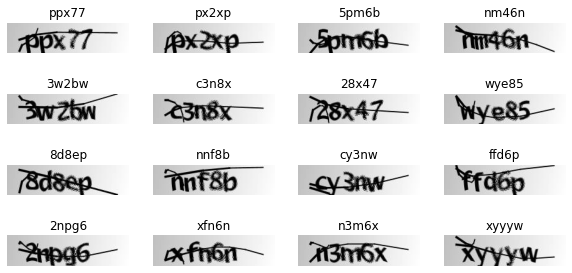

In [ ]:
#----------------------------------------------------
# Display a batch of data
#----------------------------------------------------
def display_batch(ds):
  # Get one batch and select the images and labels as separate arrays
  batch = next(iter(ds))
  images = batch["image"]
  labels = batch["label"]

  plt.figure(figsize=(10, 5))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    # Reverse the pre-processing steps so the image can be displayed
    img = (images[i] * 255).numpy().astype("uint8")
    # Since it is a grey-scale image get just two dimensions. The third
    # dimension is a dummy depth anyway.
    plt.imshow(img[:, :, 0].T, cmap="gray")
    # Get the label from the processed data by converting the character IDs to
    # text characters and then concatenating them into a string
    label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    plt.title(label)
    plt.axis("off")

display_batch(train_ds)

#### Define model

In [ ]:
#----------------------------------------------------
# Custom layer to do CTC Loss which wraps the Keras built-in CTC function. TF has a
# function but not a layer.
#----------------------------------------------------
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Keras CTC Loss function.
        self.loss_fn = keras.backend.ctc_batch_cost

    #-----------------------------
    # Layer's computation. Compute the training-time loss value and 
    # add it to the layer using `self.add_loss()`.
    #-----------------------------
    def call(self, y_true, y_pred):
      # Get the number of samples and width of true labels from 'y_true' shape.
      # Get the width of the predicted output from the width of the 'y_pred' shape. 
      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      # Since the predicted output and the true labels have been padded to a fixed
      # max length, we can provide the actual lengths for each sample. But we 
      # simply take a short cut and provide the same max fixed length for all 
      # samples.
      input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

      # Call the CTC Loss function, and include it along with any other loss
      # computed by the model. Since, in this model, there is no other loss function
      # defined, this CTC Loss becomes the only loss.
      loss = self.loss_fn(y_true, y_pred, input_length, label_length)
      self.add_loss(loss)

      # At test time, just return the computed predictions
      return y_pred

#----------------------------------------------------
# Prepare the end-to-end data pipeline
#----------------------------------------------------
def build_model(img_width, img_height, char_vocab):
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal",
                      padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal",
                      padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2. Hence, downsampled feature maps 
    # are 4x smaller. The number of filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_vocab) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return. Note that no Loss Function is provided to
    # model.compile(). That is handled via add_loss() inside the CTCLayer. When
    # we call model.fit() later, it automatically uses any loss computed via
    # add_loss to compute gradients and train the model.
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model(img_width, img_height, char_vocab)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

#### Training

In [ ]:
#----------------------------------------------------
# Run the training by calling model.fit()
#----------------------------------------------------
def do_train(model, train_ds, val_ds, num_epochs, early_stopping_patience):
  # Add early stopping
  early_stopping = keras.callbacks.EarlyStopping(
      monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
  )

  # Train the model, giving it the training and validation data
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=num_epochs,
      callbacks=[early_stopping],
  )

num_epochs = 100
early_stopping_patience = 10
do_train(model, train_ds, val_ds, num_epochs, early_stopping_patience)

Epoch 1/100
52/52 [==============================] - 3s 50ms/step - loss: 20.2436 - val_loss: 16.3926
Epoch 2/100
52/52 [==============================] - 1s 26ms/step - loss: 16.3325 - val_loss: 16.3692
Epoch 3/100
52/52 [==============================] - 1s 26ms/step - loss: 16.3364 - val_loss: 16.3603
Epoch 4/100
52/52 [==============================] - 1s 26ms/step - loss: 16.3211 - val_loss: 16.3851
Epoch 5/100
52/52 [==============================] - 1s 26ms/step - loss: 16.3147 - val_loss: 16.3889
Epoch 6/100
52/52 [==============================] - 1s 26ms/step - loss: 16.3165 - val_loss: 16.3423
Epoch 7/100
52/52 [==============================] - 1s 26ms/step - loss: 16.3112 - val_loss: 16.3208
Epoch 8/100
52/52 [==============================] - 1s 26ms/step - loss: 16.2427 - val_loss: 16.2022
Epoch 9/100
52/52 [==============================] - 1s 27ms/step - loss: 16.0187 - val_loss: 15.6948
Epoch 10/100
52/52 [==============================] - 1s 26ms/step - loss: 15.4770

#### Inference

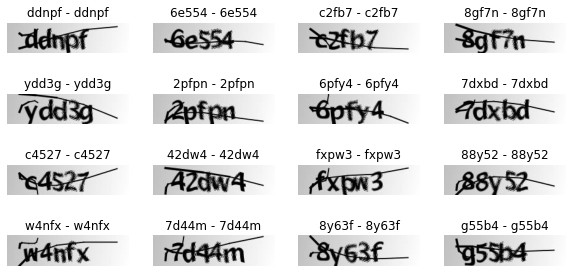

In [ ]:
#----------------------------------------------------
# Run Inference using the validation data. We use the trained model until the
# Output layer which outputs predictions and skip the last part of the model 
# which does the CTC Loss.
#----------------------------------------------------
def do_inference(model, val_ds, max_label_len):
  # Get the Input and Output layer of the trained model
  input_layer = model.get_layer("image")
  pred_layer = model.get_layer("dense2")
  # Define a prediction model that uses the complete trained model except for the
  # CTC Loss
  prediction_model = keras.models.Model(inputs=input_layer.input, outputs=pred_layer.output)

  # Get validation batches, and get predicted scores from the model. Get final
  # output labels by passing those predicted scores to the Keras built-in CTC Decode
  # function.
  #
  # CTC Loss computes a Loss value from the predicted scores by comparing it to the
  # true labels. CTC Decode does not compute loss, but instead has the option of using
  # either Greedy or Beam Search to get the final predicted labels.
  for batch in val_ds.take(1):
    images = batch["image"]
    labels = batch["label"]
    # Get predicted scores from the model. We use the max fixed width as the predicted
    # length for all samples.
    pred_scores = prediction_model(images)
    pred_lengths = np.ones(pred_scores.shape[0])*pred_scores.shape[1]
    # Get the predicted labels using CTC Decode, using the default Greedy Search but
    # we can also set it to use Beam Search.
    pred_ids = keras.backend.ctc_decode(pred_scores, input_length=pred_lengths, greedy=True)[0][0][:, :max_label_len]

    # Display the decoded predictions along with the true labels for each image
    plt.figure(figsize=(10, 5))
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      img = (images[i] * 255).numpy().astype("uint8")
      plt.imshow(img[:, :, 0].T, cmap="gray")
      pred_label = tf.strings.reduce_join(num_to_char(pred_ids[i])).numpy().decode("utf-8")
      target_label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
      plt.title(f'{pred_label} - {target_label}')
      plt.axis("off")

do_inference(model, val_ds, max_label_len)

#### Beam Search

In [ ]:
from math import log
from numpy import array
from numpy import argmax
 
#----------------------------------------------------
# beam search
# At each step, each candidate sequence is expanded with all possible next steps. 
# Each candidate step is scored by multiplying the probabilities together. The k sequences 
# with the most likely probabilities are selected and all other candidates are pruned. 
# This is done by sorting all candidate sequences in ascending order by their score 
# and selecting the first k as the most likely candidate sequences.
# The process then repeats until the end of the sequence.
# Since probabilities are small numbers, we instead take the natural logarithm of the 
# probabilities and add them
#----------------------------------------------------
def beam_search_decoder(data, k):
  # 'sequences' is list of lists. Each sub-list has two items - [[the sequence of words], score]
  # It always has length = k, and stores the k best sequences so far
  # eg. [[[4, 0, 4, 0], 2.77], [[4, 0, 4, 1], 2.99], [[4, 0, 3, 0], 2.99]]
  sequences = [[list(), 0.0]]
  # walk over each step in sequence
  for row in data:
    all_candidates = list()
    # expand each current best sequence
    for i in range(len(sequences)):
      seq, score = sequences[i]
      # Take each word from the vocab, add it to the existing best sequence and
      # compute the score of the appended sequence
      for j in range(len(row)):
        # Generate a new candidate by appending each word in the vocab to the existing
        # best sequence, and computing its score by subtracting the log probability of
        # the new word from the score of the existing sequence
        candidate = [seq + [j], score - log(row[j])]
        all_candidates.append(candidate)
    # order all candidates by score
    # 'all_candidates' has the same structure as 'sequences', but it has all possible
    # sequences so far with their score. It has length = k * vocab_size
    # [[[4, 0, 4, 0], 2.77], [[4, 0, 4, 1], 2.99], [[4, 0, 3, 0], 2.99], [[4, 1, 4, 0], 2.99], [[4, 0, 3, 1], 3.21], [[4, 1, 4, 1], 3.21], ...]
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]
  return sequences
 
# define a sequence of 10 words over a vocab of 5 words
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1]]
data = array(data)
# decode sequence
result = beam_search_decoder(data, 3)
# print result
for seq in result:
	print(seq)

[[4, 0, 4, 0, 4, 0, 4, 0, 4, 0], 6.931471805599453]
[[4, 0, 4, 0, 4, 0, 4, 0, 4, 1], 7.154615356913663]
[[4, 0, 4, 0, 4, 0, 4, 0, 3, 0], 7.154615356913663]
